In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

In [2]:
from flow_assignment.flow_assignment import FlowAssignment
from geoprocessing.faf_zone_network import FafZoneNetwork, link_weights
from flow_assignment.mc_flow_assignment import sample_flows
import geopandas as gpd

In [3]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/2017_CFS_Metro_Areas_with_FAF").to_crs(4326)
faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow.csv' )


In [4]:
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
fzn.network_weight_fn = link_weights
railnet = fzn.createNetwork()#(write_to=BASE_DIR / "resources/networks/faf_railnet.gml")


/home/nathanczh/ctsm/faf_flow_assignment/src/geoprocessing/faf_zone_network.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fafZoneNodesDf.geometry = fafZoneNodesDf.centroid


Preprocessed


/home/nathanczh/ctsm/faf_flow_assignment/src/geoprocessing/faf_zone_network.py:145: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['distance'] = df['geometry_fr'].distance(df['geometry_to'])


In [5]:

fa = FlowAssignment(railnet)
MONTE_CARLO = True
COLUMN = 'thousand tons in 2050'

railnet_flows = fa.run(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode
if not MONTE_CARLO:
  fzn.apply_flows(railnet_flows.to_dict())

if MONTE_CARLO:
  ITER_N = 500

  monte_railnet_flows = []
  monte_inputs = []
  for i in range(ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN)
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(ITER_N)
  monte_railnet_flows

In [13]:
fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)

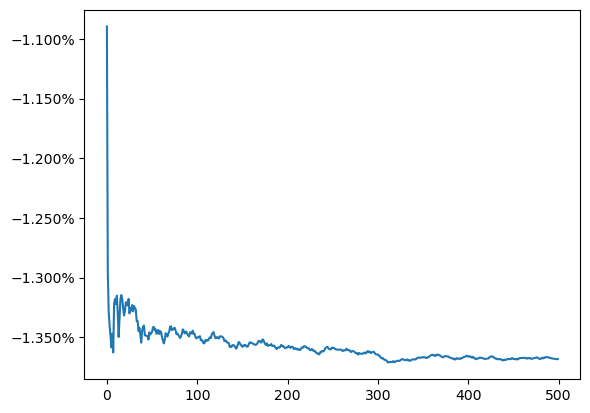

In [14]:
from matplotlib.ticker import PercentFormatter

plot = monte_railnet_flows.sub(railnet_flows, axis=0).div(railnet_flows, axis=0).mul(100, axis=0).T.expanding().mean().mean(axis=1).plot()
plot.yaxis.set_major_formatter(PercentFormatter())

,FAF_Zone_1_fr,FAF_Zone_1_to,flows
0,Remainder of Colorado,New Mexico,71749.930
1,Arkansas,Remainder of Texas,70547.452
2,Remainder of Illinois,Remainder of Indiana,59290.738
3,Idaho,Remainder of Washington,59190.030
4,Iowa,Remainder of Missouri,55037.450
...,...,...,...
250,Remainder of Connecticut,"Boston-Worcester-Providence, MA-RI-NH-CT CFS ...",0.000
251,"Cincinnati-Wilmington-Maysville, OH-KY-IN CFS...","Cincinnati-Wilmington-Maysville, OH-KY-IN CFS...",0.000
252,"New York-Newark, NY-NJ-CT-PA CFS Area (NJ Part)","New York-Newark, NY-NJ-CT-PA CFS Area (PA Part)",0.000
253,"Columbus-Marion-Zanesville, OH CFS Area","Dayton-Springfield-Sidney, OH CFS Area",0.000


<Axes: title={'center': 'Histogram of freight flows'}, xlabel='Millions of Tons per year', ylabel='Frequency'>

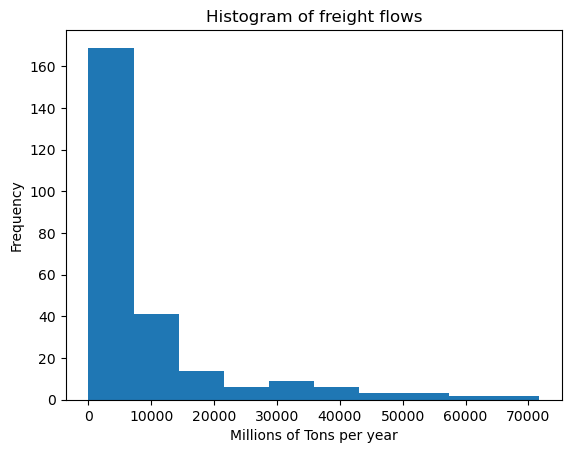

In [16]:
import folium
import branca.colormap as cm
from IPython.display import display

min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  max_lat=max_lat,
  min_lon=min_lon,
  max_lon=max_lon,
  min_lat=min_lat
)

# m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

wmax = fzn.fafZoneLinksDf['flows'].max()
wmin = fzn.fafZoneLinksDf['flows'].min()
def norm_w(feature):
  return (feature['properties']['flows'] - wmin)/(wmax-wmin)

lineWeightMax = 4
lineWeightMin = 0.75

fzn.fafZoneLinksDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows', 'geometry']].explore(
  m=m,
  column='flows',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(norm_w(feature)),
      'weight': norm_w(feature) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  }
)

fzn.fafZoneNodesDf[['FAF_Zone_1', 'geometry']].explore(
  m=m,
  color='black'
)

folium.LayerControl().add_to(m)
display(m)
display(fzn.fafZoneLinksDf.sort_values('flows', axis=0, ascending=False).reset_index()[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows']])
display(fzn.fafZoneLinksDf['flows'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
))